## Tutorial for ATAC to RNA Cross-Modality Generation Step 1

Hi, this is the tutorial for ATAC to RNA(denoted as A2R) cross-modality generation. We take the MISAR-seq dataset as an example in this task. Detailed results about this task will be found in figure 3 in our paper.

To be specific, our model input is three types of data: 
* a set of paired spatial multi-omics data from the same slice (denoted as S1R and S1A in our paper and figure 1) 
* a single-modality spatial data from another slice (denoted as S2A in our paper and figure 1) 

Our target is to generate the missing modality for S2, that is S2R.

To complete this task, we need to take several steps:

(1) Batch Correction. Considering the huge batch effect between slices, we first need to remove batch effects between the same modality of different slices (i.e. S1A and S2A). After this step, we will get two latent embeddings without batch for two slices respectively.

(2) Modality Pretrain. We need to get the embedding for another modality (S1R).

(3) Cross Generation. We use the two paired embeddings from S1A and S1R and train the generative model.

(4) Inference: After training the model, we freeze all the parameters and use the embedding from S2A and input it through the frozen network from (3). Once we get the generated embedding, we use the frozen decoder from (2) and get the final whole matrix, called S2 A2R_predict.

We divide the whole process into 2 files. This file is step 1, which is batch correction module. After running this ipynb file, please go to step 2 to do generation task.


## Preparation

In [3]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys
import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.sparse as sp
import scipy.linalg
import torch
import episcanpy.api as epi
used_device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [2]:
import SpaTranslator as spt


    _____               ______                           __        __              
   / ___/ ____   ____ _/_  __/_____ ____ _ ____   _____ / /____ _ / /_ ____   _____
   \__ \ / __ \ / __ `/ / /  / ___// __ `// __ \ / ___// // __ `// __// __ \ / ___/
  ___/ // /_/ // /_/ / / /  / /   / /_/ // / / /(__  )/ // /_/ // /_ / /_/ // /    
 /____// .___/ \__,_/ /_/  /_/    \__,_//_/ /_//____//_/ \__,_/ \__/ \____//_/     
      /_/                                                                           

SpaTranslator v1.0.8     



## Load Data and Preprocessing

In [ ]:
import os
os.chdir('/home/yourworkpath/SpatialTranslator')

We load two dataset: ATAC-seq data for slice 1 and 2.

In [4]:
slice_name_list =['E15_5-S1','E15_5-S2'] 

# load raw data
cas_dict = {}
for sample in slice_name_list:
    sample_data = ad.read_h5ad('To_train_' + sample + '_atac.h5ad')
    cas_dict[sample] = sample_data
cas_list = [cas_dict[sample] for sample in slice_name_list]
# merge peaks

In [5]:
cas_list[0]

AnnData object with n_obs × n_vars = 1949 × 265014
    obs: 'gex_barcode', 'atac_barcode', 'is_cell', 'excluded_reason', 'gex_raw_reads', 'gex_mapped_reads', 'gex_conf_intergenic_reads', 'gex_conf_exonic_reads', 'gex_conf_intronic_reads', 'gex_conf_exonic_unique_reads', 'gex_conf_exonic_antisense_reads', 'gex_conf_exonic_dup_reads', 'gex_exonic_umis', 'gex_conf_intronic_unique_reads', 'gex_conf_intronic_antisense_reads', 'gex_conf_intronic_dup_reads', 'gex_intronic_umis', 'gex_conf_txomic_unique_reads', 'gex_umis_count', 'gex_genes_count', 'atac_raw_reads', 'atac_unmapped_reads', 'atac_lowmapq', 'atac_dup_reads', 'atac_chimeric_reads', 'atac_mitochondrial_reads', 'atac_fragments', 'atac_TSS_fragments', 'atac_peak_region_fragments', 'atac_peak_region_cutsites', 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'Gex_RiboRatio', 'Gex_nUMI', 'Gex_nGenes', 'Gex_Mito

In [6]:
cas_list[0].var_names

Index(['chr1:3094810-3095311', 'chr1:3120251-3120752', 'chr1:3184960-3185461',
       'chr1:3360849-3361350', 'chr1:3399870-3400371', 'chr1:3414009-3414510',
       'chr1:3514678-3515179', 'chr1:3552386-3552887', 'chr1:3670824-3671325',
       'chr1:3671548-3672049',
       ...
       'chrY:90799093-90799594', 'chrY:90800223-90800724',
       'chrY:90801342-90801843', 'chrY:90803330-90803831',
       'chrY:90807496-90807997', 'chrY:90808593-90809094',
       'chrY:90810719-90811220', 'chrY:90811533-90812034',
       'chrY:90812148-90812649', 'chrY:90812685-90813186'],
      dtype='object', name='index', length=265014)

Considering that the data.var index between two dataset is a little different (for example, in one dataset is chr1:3094810-3095311, while in the other is chr1:3094830-3095331, which has a bias). Therefore, we use the alignment function to correct bias.

In [7]:
cas_list_new = spt.peak_sets_alignment(cas_list)

Peak merged
Peak filtered
Matrix merged


In [8]:
cas_list = cas_list_new

In [9]:
for j in range(len(cas_list)):
    cas_list[j].obs_names = [x + '_' + slice_name_list[j] for x in cas_list[j].obs_names]

# concatenation
adata_concat = ad.concat(cas_list, label="slice_name", keys=slice_name_list)

In [10]:
# from SpaTranslator.utils import preprocess_CAS
spt.preprocess_CAS(cas_list, adata_concat, use_fragment_count=True, min_cells_rate=0.03)

In [11]:
for i in range(len(slice_name_list)):
    cas_list[i].write_h5ad("filtered_merged_"+slice_name_list[i]+"_atac.h5ad")

We construct the spatial graph by using KNN method.

In [ ]:

Batch_list = []
adj_list = []
section_ids = ['E15_5-S1_atac','E15_5-S2_atac']
for section_id in section_ids:
    print(section_id)
    adata = sc.read_h5ad("filtered_merged_"+ section_id + '.h5ad')
    adata.var_names_make_unique()
    spt.build_spatial_graph(adata, knn_neighbors = 6, method ='KNN')
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=15000)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata = adata[:, adata.var['highly_variable']]

    adj_list.append(adata.uns['adj_matrix'])
    Batch_list.append(adata)
    print(adata.shape)
    

E15_5-S1_atac
Constructing the spatial graph
Generated graph with 11694 edges across 1949 cells.
Average neighbors per cell: 6.0000
(1949, 15000)
E15_5-S2_atac
Constructing the spatial graph
Generated graph with 11634 edges across 1939 cells.
Average neighbors per cell: 6.0000
(1939, 15000)


In [13]:
adata_concat = ad.concat(Batch_list, label="slice_name", keys=section_ids)

In [14]:
adata_concat

AnnData object with n_obs × n_vars = 3888 × 7199
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'Gex_RiboRatio', 'Gex_nUMI', 'Gex_nGenes', 'Gex_MitoRatio', 'BlacklistRatio', 'array_col', 'array_row', 'cell_type', 'slice_name'
    obsm: 'insertion', 'spatial'

We concat the scanpy objects for multiple slices

In [ ]:

adata_concat.obs["batch_name"] = adata_concat.obs["slice_name"].astype('category')
print('adata_concat.shape: ', adata_concat.shape)

adata_concat.shape:  (3888, 7199)


We concat the spatial network for multiple slices

In [16]:
adj_concat = np.asarray(adj_list[0].todense())
for batch_id in range(1,len(section_ids)):
    adj_concat = scipy.linalg.block_diag(adj_concat, np.asarray(adj_list[batch_id].todense()))
adata_concat.uns['edgeList'] = np.nonzero(adj_concat)

## Train the model


In [ ]:
adata_concat = spt.train_spatial_aligner(adata_concat, verbose=True, knn_neighbors = 50, device=used_device)

SpaTranslator_Aligner(
  (encoder_layer1): GraphAttentionLayer(7199, 512, heads=1)
  (encoder_layer2): GraphAttentionLayer(512, 128, heads=1)
  (decoder_layer1): GraphAttentionLayer(128, 512, heads=1)
  (decoder_layer2): GraphAttentionLayer(512, 7199, heads=1)
)
Pretraining


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 138.25it/s]


Training with MNN loss


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [05:22<00:00,  1.55it/s]


In [18]:
adata_concat.X.toarray()

array([[0.68847783, 0.08623467, 0.        , ..., 0.        , 0.0440466 ,
        0.        ],
       [0.72434698, 0.2020181 , 0.        , ..., 0.10610181, 0.        ,
        0.        ],
       [0.79464059, 0.0926627 , 0.        , ..., 0.0926627 , 0.        ,
        0.04740426],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

## Showing Result 

We use the following code to get the aligned embeddings and plot them in 2D-UMAP to see that whether they are aligned well.

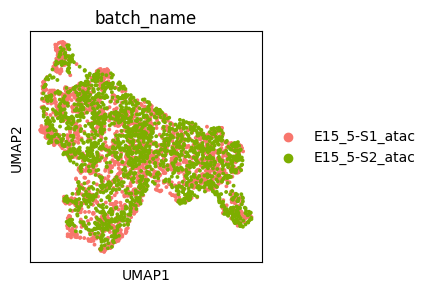

In [ ]:
sc.pp.neighbors(adata_concat, use_rep='AlignedEmbedding', random_state=666)
sc.tl.umap(adata_concat, random_state=666)
section_color = ['#f8766d', '#7cae00']
section_color_dict = dict(zip(section_ids, section_color))
adata_concat.uns['batch_name_colors'] = [section_color_dict[x] for x in adata_concat.obs.batch_name.cat.categories]
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata_concat, color='batch_name',ncols = 1,
           wspace=0.5, show=True)

In [20]:
adata_concat.obsm['AlignedEmbedding'].shape

(3888, 128)

In [21]:
adata_concat

AnnData object with n_obs × n_vars = 3888 × 7199
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'Gex_RiboRatio', 'Gex_nUMI', 'Gex_nGenes', 'Gex_MitoRatio', 'BlacklistRatio', 'array_col', 'array_row', 'cell_type', 'slice_name', 'batch_name'
    uns: 'edgeList', 'neighbors', 'umap', 'batch_name_colors'
    obsm: 'insertion', 'spatial', 'SpaAligner', 'AlignedEmbedding', 'X_umap'
    obsp: 'distances', 'connectivities'

In [22]:
adata_concat.obs['slice_name']

GCCGCAACGCCGCAAC-1_E15_5-S1    E15_5-S1_atac
GCCATTCTGCCATTCT-1_E15_5-S1    E15_5-S1_atac
TGCGGACCTGCGGACC-1_E15_5-S1    E15_5-S1_atac
ACTATGCAACTATGCA-1_E15_5-S1    E15_5-S1_atac
TAGATCTATAGATCTA-1_E15_5-S1    E15_5-S1_atac
                                   ...      
TTATTCATGAAGATCG-1_E15_5-S2    E15_5-S2_atac
TTATTCATATAAGGAG-1_E15_5-S2    E15_5-S2_atac
ATCATATTTCCGGCCT-1_E15_5-S2    E15_5-S2_atac
ACTTAACCGGTATGCT-1_E15_5-S2    E15_5-S2_atac
GCCGCAACATAAGGAG-1_E15_5-S2    E15_5-S2_atac
Name: slice_name, Length: 3888, dtype: category
Categories (2, object): ['E15_5-S1_atac', 'E15_5-S2_atac']

## Save the Results and Embeddings

In [23]:
E15_S1 = sc.read_h5ad('To_train_' + 'E15_5-S1'+ '_atac.h5ad')
E15_S1

AnnData object with n_obs × n_vars = 1949 × 265014
    obs: 'gex_barcode', 'atac_barcode', 'is_cell', 'excluded_reason', 'gex_raw_reads', 'gex_mapped_reads', 'gex_conf_intergenic_reads', 'gex_conf_exonic_reads', 'gex_conf_intronic_reads', 'gex_conf_exonic_unique_reads', 'gex_conf_exonic_antisense_reads', 'gex_conf_exonic_dup_reads', 'gex_exonic_umis', 'gex_conf_intronic_unique_reads', 'gex_conf_intronic_antisense_reads', 'gex_conf_intronic_dup_reads', 'gex_intronic_umis', 'gex_conf_txomic_unique_reads', 'gex_umis_count', 'gex_genes_count', 'atac_raw_reads', 'atac_unmapped_reads', 'atac_lowmapq', 'atac_dup_reads', 'atac_chimeric_reads', 'atac_mitochondrial_reads', 'atac_fragments', 'atac_TSS_fragments', 'atac_peak_region_fragments', 'atac_peak_region_cutsites', 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'Gex_RiboRatio', 'Gex_nUMI', 'Gex_nGenes', 'Gex_Mito

In [24]:
E15_S1.obsm['AlignedEmbedding'] = adata_concat.obsm['AlignedEmbedding'][0:1949, :]
E15_S1.write_h5ad('After_train_' + 'E15_5-S1' + '_atac.h5ad')

In [25]:
E15_S2 = sc.read_h5ad('To_train_' + 'E15_5-S2'+ '_atac.h5ad')

In [26]:
E15_S2

AnnData object with n_obs × n_vars = 1939 × 244394
    obs: 'tsse', 'n_fragment', 'frac_dup', 'frac_mito', 'sample', 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'Gex_RiboRatio', 'Gex_nUMI', 'Gex_nGenes', 'Gex_MitoRatio', 'BlacklistRatio', 'array_col', 'array_row', 'Combined_Clusters', 'RNA_Clusters', 'ATAC_Clusters', 'cell_type'
    uns: 'peaks', 'reference_sequences'
    obsm: 'insertion', 'spatial'

In [27]:
adata_concat.obsm['AlignedEmbedding'][1949:, :].shape

(1939, 128)

In [28]:
adata_concat.obs['slice_name'].iloc[1949:]

GCAGGTCCGCAGGTCC-1_E15_5-S2    E15_5-S2_atac
TAGATCTATAGATCTA-1_E15_5-S2    E15_5-S2_atac
CAACCGCTCAACCGCT-1_E15_5-S2    E15_5-S2_atac
TAGAGTAATAGAGTAA-1_E15_5-S2    E15_5-S2_atac
ACTATGCAACTATGCA-1_E15_5-S2    E15_5-S2_atac
                                   ...      
TTATTCATGAAGATCG-1_E15_5-S2    E15_5-S2_atac
TTATTCATATAAGGAG-1_E15_5-S2    E15_5-S2_atac
ATCATATTTCCGGCCT-1_E15_5-S2    E15_5-S2_atac
ACTTAACCGGTATGCT-1_E15_5-S2    E15_5-S2_atac
GCCGCAACATAAGGAG-1_E15_5-S2    E15_5-S2_atac
Name: slice_name, Length: 1939, dtype: category
Categories (2, object): ['E15_5-S1_atac', 'E15_5-S2_atac']

In [29]:
E15_S2.obsm['AlignedEmbedding'] = adata_concat.obsm['AlignedEmbedding'][1949:, :]

In [30]:
E15_S2.write_h5ad('After_train_' + 'E15_5-S2' + '_atac.h5ad')